# Example of upper limit computation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lauztat
from lauztat.parameters import POI
from lauztat.hypotests import UpperLimit
from lauztat.calculators import AsymptoticCalculator
from lauztat.config import Config

In [2]:
import tensorflow as tf
import zfit
from zfit import ztf
from zfit.core.loss import ExtendedUnbinnedNLL, UnbinnedNLL
from zfit.minimizers.minimizer_minuit import MinuitMinimizer

## Scenario

Let's assume you want to find a resonnance between 0.1 and 3.0 GeV/c$^2$ of invariant mass of a system.

You have a signal region and a background only region:

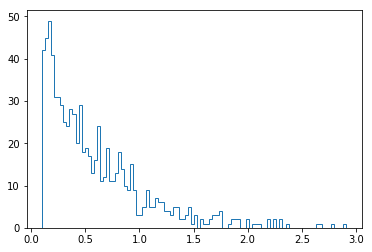

In [3]:
bounds = (0.1, 3.0)

#background only
np.random.seed(10)
tau = 2.0
beta = 1./tau
data = np.random.exponential(beta, 1000)

data_bkg = data[(data > bounds[0]) & (data < bounds[1])]
plt.hist(data_bkg, bins=100, histtype='step');

In [4]:
#signal + background

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 10)
data = np.concatenate((data,peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

### Background fit, in background only region:

The background model is an exponential.

In [5]:
obs = zfit.Space('x', limits=bounds)

In [6]:
lambda_ = zfit.Parameter("lambda_",-2.0, -4.0, -0.5)
model_bkg = zfit.pdf.Exponential(obs=obs, lambda_=lambda_)

In [7]:
data_bkg_ = zfit.data.Data.from_numpy(obs=obs, array=data_bkg)
nll_bkg = UnbinnedNLL(model=[model_bkg], data=[data_bkg_], fit_range=[obs]) 

In [8]:
minimizer = MinuitMinimizer()

In [9]:
min_bkg = minimizer.minimize(loss=nll_bkg)

FCN = 222.3887201920576 
 TOTAL NCALL = 18 
 NCALLS = 18 
 
 
 EDM = 7.000513472127701e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,lambda_,-2.02215,0.0748428,,,-4,-0.5,No


In [10]:
min_bkg.params[lambda_]

{'value': -2.022148383099551}

In [11]:
min_bkg.error();

Error,-0.07588040251832025,0.07423887392248027
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


In [12]:
lambda_mu = min_bkg.params[lambda_]["value"]
lambda_sigma = 0.0748696
print(lambda_mu, lambda_sigma)

-2.022148383099551 0.0748696


### Signal + background fit in signal region:

The total model is a sum of a gaussian and an exponential. The tau parameter of the exponential will be constrained to the value obtained in the background only region.

In [13]:
mean = zfit.Parameter("mean", 1.2, 0.1, 2., floating=False)
sigma = zfit.Parameter("sigma", 0.1, floating=False)
Nsig = zfit.Parameter("Nsig", 1., -20., len(data))
Nbkg = zfit.Parameter("Nbkg", len(data), 0., len(data)*1.1)

In [14]:
signal = Nsig * zfit.pdf.Gauss(obs=obs, mu=mean, sigma=sigma)
background =  Nbkg * model_bkg
tot_model = signal + background

In [15]:
constraint = zfit.constraint.nll_gaussian(params=[lambda_], mu=[lambda_mu], sigma=[lambda_sigma])

In [16]:
data_ = zfit.data.Data.from_numpy(obs=obs, array=data)
nll = ExtendedUnbinnedNLL(model=[tot_model], data=[data_], fit_range=[obs], constraints=constraint) 

In [17]:
minimum = minimizer.minimize(loss=nll)

FCN = -1077.310240591382 
 TOTAL NCALL = 68 
 NCALLS = 68 
 
 
 EDM = 3.5986943907360196e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,Nbkg,250.489,16.4979,,,0,281.6,No
1,Nsig,5.54888,5.48929,,,-20,256,No
2,lambda_,-2.00252,0.0665315,,,-4,-0.5,No


In [18]:
def plotfitresult(pdf, bounds, nbins, data):
    x = np.linspace(*bounds, num=1000)
    pdf = zfit.run(tot_model.pdf(x, norm_range=bounds))
    _ = plt.plot(x, ((bounds[1] - bounds[0])/nbins)*(pdf), "-r")  

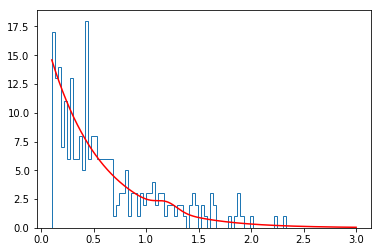

In [19]:
nbins = 100
plt.hist(data, bins=nbins, histtype='step', range=bounds);
plotfitresult(tot_model, bounds, nbins, data)

## Upper limit:

In [20]:
def lossbuilder(model, data):
    constraint = zfit.constraint.nll_gaussian(params=[lambda_], mu=[lambda_mu], sigma=[lambda_sigma])
    loss = ExtendedUnbinnedNLL(model=model, data=data, fit_range=[obs], constraints=constraint) 
    return loss

config = Config(tot_model, data_, lossbuilder, MinuitMinimizer())

In [21]:
config.bestfit

Get fit best values!


FCN = -1077.3102440274733 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = 3.257227226646795e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,Nbkg,250.489,16.5065,,,0,281.6,No
1,Nsig,5.54888,5.49019,,,-20,256,No
2,lambda_,-2.00246,0.0665316,,,-4,-0.5,No


In [22]:
calc = AsymptoticCalculator(config)

In [23]:
poinull = POI(Nsig, value=np.linspace(0.0, 25, 20))
poialt = POI(Nsig, value=0)
ul_test = UpperLimit(poinull, poialt, calc, CLs=True, qtilde=False)

In [24]:
ul_test.CLs = True

Compute qobs for the null hypothesis!

Get fit best values for nuisance parameters for the alternative hypothesis!


FCN = -1076.7139454781395 
 TOTAL NCALL = 48 
 NCALLS = 48 
 
 
 EDM = 7.671303274034628e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,Nbkg,255.99,15.8924,,,0,281.6,No
1,lambda_,-1.9881,0.0650271,,,-4,-0.5,No


In [25]:
ul_test.qtilde = False

Compute qobs for the null hypothesis!


In [26]:
ul_test.upperlimit();


Observed upper limit: Nsig = 16.177011091681415
Expected upper limit: Nsig = 11.121936864081809
Expected upper limit +1 sigma: Nsig = 16.14081320799071
Expected upper limit -1 sigma: Nsig = 7.8224171738762625
Expected upper limit +2 sigma: Nsig = 22.850786174760028
Expected upper limit -2 sigma: Nsig = 5.771112271018672


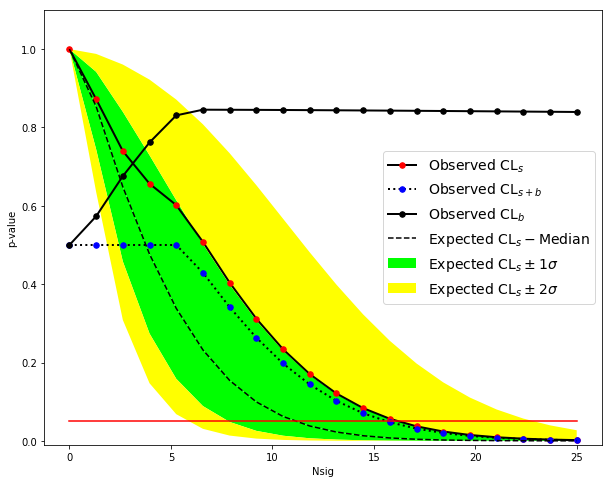

In [27]:
ul_test.plot()